In [1]:
from postgres import Postgres
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import ast
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

pg = Postgres()

results = pg.query(
    """
 SELECT 
	cmetadata->'text' as text,
	embedding
    FROM langchain_pg_embedding 
	WHERE cmetadata @> '{"chunker": "sherpa"}' 
    AND LENGTH(cmetadata->>'text'::TEXT) > 40
	LIMIT 5000;
                   
	"""
)


df = pd.DataFrame(results, columns=["text", "embedding"])
df["embedding"] = df["embedding"].apply(ast.literal_eval)
print(type(df["embedding"][0]))
embeddings_array = np.array(df["embedding"].tolist())
print(embeddings_array.shape)

<class 'list'>
(2800, 1536)


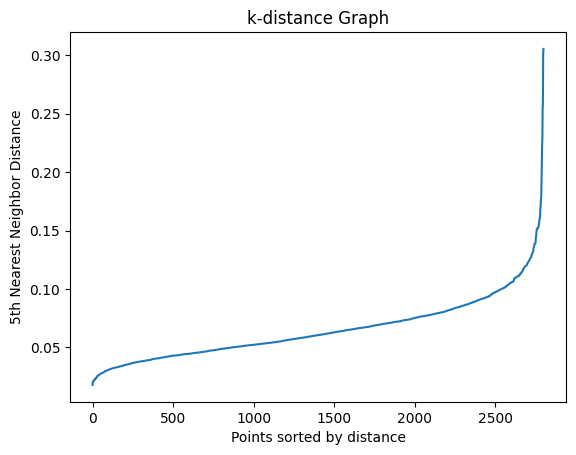

Number of clusters found: 19
Cluster 0 Top Words:
local: 3524
development: 3305
plan: 3273
area: 2566
community: 2094
parish: 1935
neighbourhood: 1879
village: 1868
policy: 1638
new: 1536
-  Development proposals that result in the improvement and expansion of community facilities or the provision of new community facilities will be supported subject to the following criteria being met:   • The proposal will not adversely affect residential amenity or the living conditions of the occupiers of neighbouring properties;  • The proposal will not lead to traffic congestion or adversely affect the free flow of traffic; and  • Access arrangements and off-street parking including cycle parking to promote active travel can be satisfactorily provided.     Proposals to redevelop, extend or replace an existing community facility through enabling development on part or all of the land or buildings occupied by the existing community facility, will be supported where it can be demonstrated through vi

In [2]:
# Function to tokenize text and remove stop words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [
        word for word in tokens if word.isalpha() and word not in stop_words
    ]
    return filtered_tokens


tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_array)

# Standardize the data
scaler = StandardScaler()
reduced_embeddings = scaler.fit_transform(reduced_embeddings)

df["reduced_embedding"] = list(reduced_embeddings)

# Plot k-distance graph to find optimal eps
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(reduced_embeddings)
distances, indices = nbrs.kneighbors(reduced_embeddings)
distances = np.sort(distances, axis=0)
distances = distances[:, 4]
plt.plot(distances)
plt.title("k-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.show()

# Set eps based on the elbow of the k-distance graph
eps_value = 0.15  # Adjust this value based on the graph
min_samples_value = 5  # Adjust this value as needed


# Clustering
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(reduced_embeddings)
df["cluster"] = clusters

# Print the number of clusters found
num_unique_clusters = len(set(clusters))
print(f"Number of clusters found: {num_unique_clusters}")

df["tokens"] = df["text"].apply(preprocess_text)

# Compute word frequencies for each cluster
for cluster in range(1000):
    cluster_df = df[df["cluster"] == cluster]
    if not cluster_df.empty:
        cluster_tokens = df[df["cluster"] == cluster]["tokens"].explode()
        word_freq = Counter(cluster_tokens)
        most_common_words = word_freq.most_common(10)  # Top 10 words
        print(f"Cluster {cluster} Top Words:")
        for word, freq in most_common_words:
            print(f"{word}: {freq}")

        sample_docs = (
            df[df["cluster"] == cluster]["text"].sample(5, replace=True).tolist()
        )
        for doc in sample_docs:
            print(f"- {doc}")
        print("\n")

        print("\n")